### imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import torch
import torch.nn as nn
import gradio as gr
from PIL import Image, ImageOps


from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.utils import to_categorical
import cv2


c:\Users\laphouse\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### load data

In [2]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()


### `EDA`

In [3]:
# basic dimensions checking
print("Shapes:")
print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

Shapes:
x_train shape: (60000, 28, 28)
y_train shape: (60000,)
60000 train samples
10000 test samples


In [4]:
# Check unique labels
print("Unique labels:", np.unique(y_train))

Unique labels: [0 1 2 3 4 5 6 7 8 9]


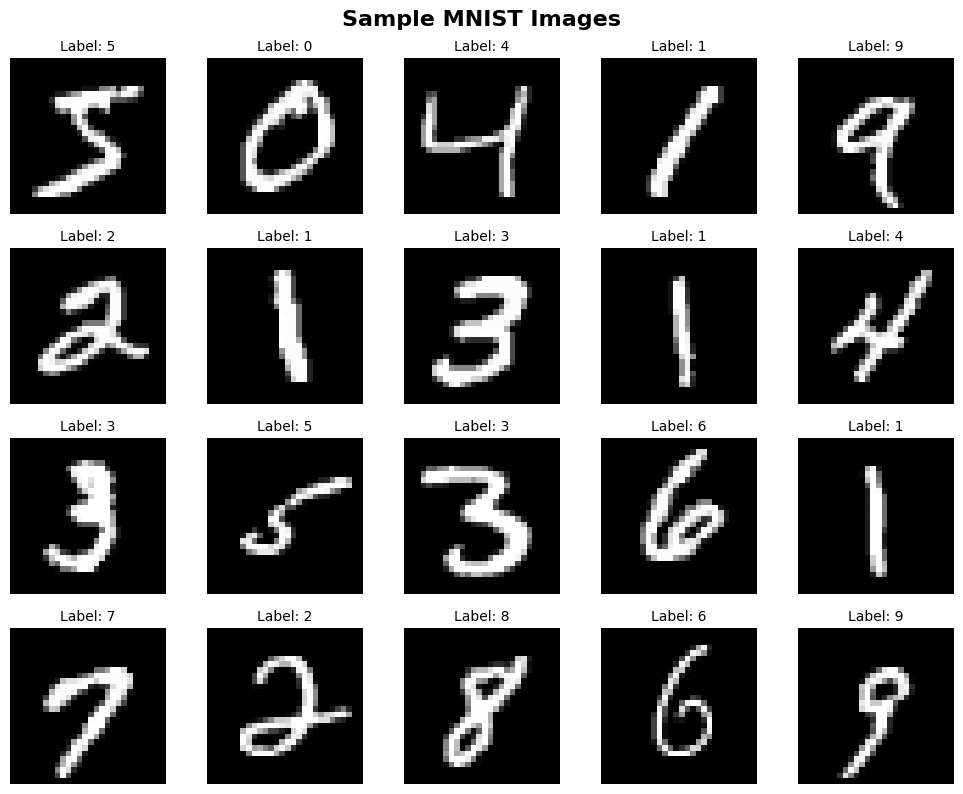

In [5]:
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f'Label: {y_train[i]}', fontsize=10)
    plt.axis('off')

plt.suptitle('Sample MNIST Images', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [6]:
# pixel info
print("Minimum pixel value:", np.min(X_train))
print("Maximum pixel value:", np.max(X_train))
print("Mean pixel value:", np.mean(X_train))

Minimum pixel value: 0
Maximum pixel value: 255
Mean pixel value: 33.318421449829934


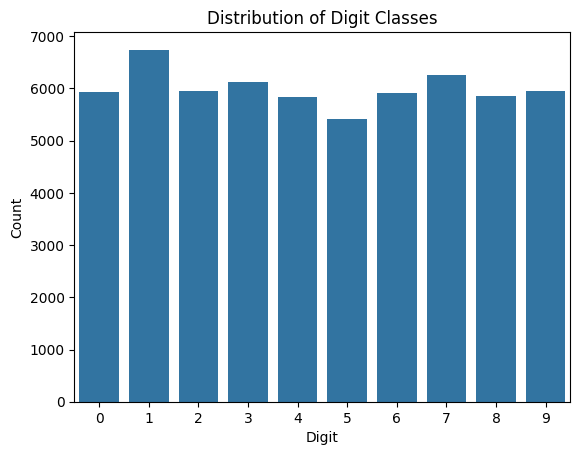

In [7]:
# check balance 
sns.countplot(x=y_train)
plt.title("Distribution of Digit Classes")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()

- dataset nearly balanced

### `preprocessing`

In [8]:
# scale pixels
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0


In [9]:
# Flatten the images for MLP
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

### `Train MLP`

In [10]:
# Train MLP on MNIST
mlp_mnist = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64, 32),
    activation='relu',
    solver='adam',
    max_iter=100,
    random_state=42
)

print("Training MLP on MNIST dataset...")
mlp_mnist.fit(X_train_flat, y_train)

Training MLP on MNIST dataset...


MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32), max_iter=100,
              random_state=42)

### `Evalution`

In [11]:
# Accuracy and Classification Report
y_pred = mlp_mnist.predict(X_test_flat)
acc_mnist = accuracy_score(y_test, y_pred)
print(f"MNIST Accuracy: {acc_mnist:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

MNIST Accuracy: 0.9831

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.99      0.98      0.98      1010
           4       0.97      0.99      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.98      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



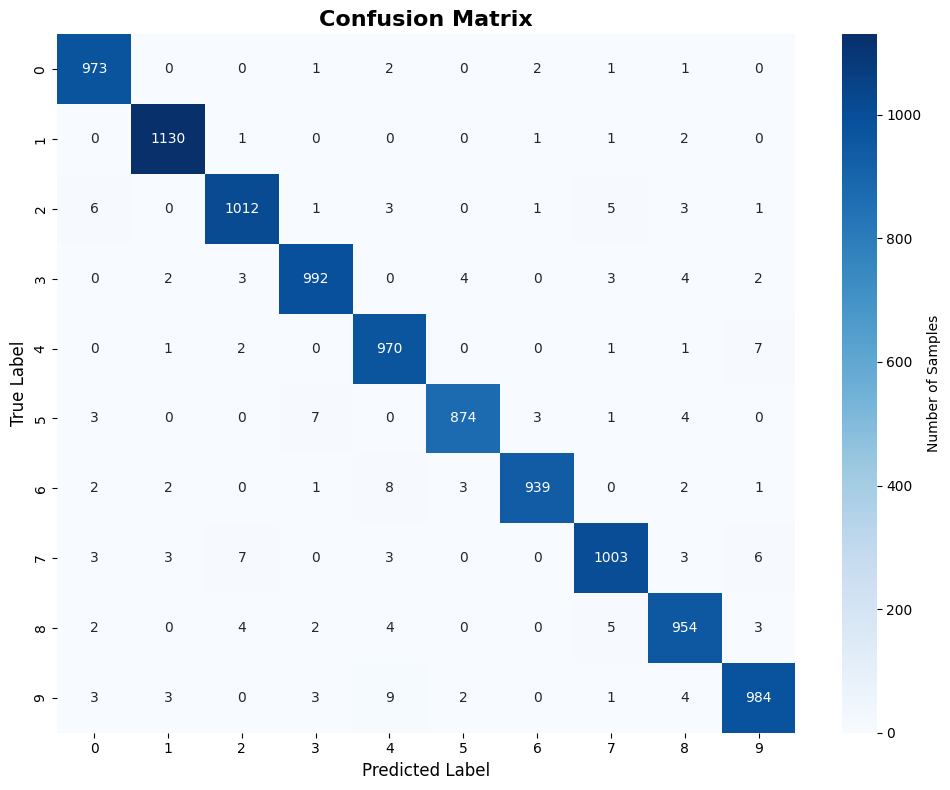

In [12]:
# Create visualization plots
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10),
            cbar_kws={'label': 'Number of Samples'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

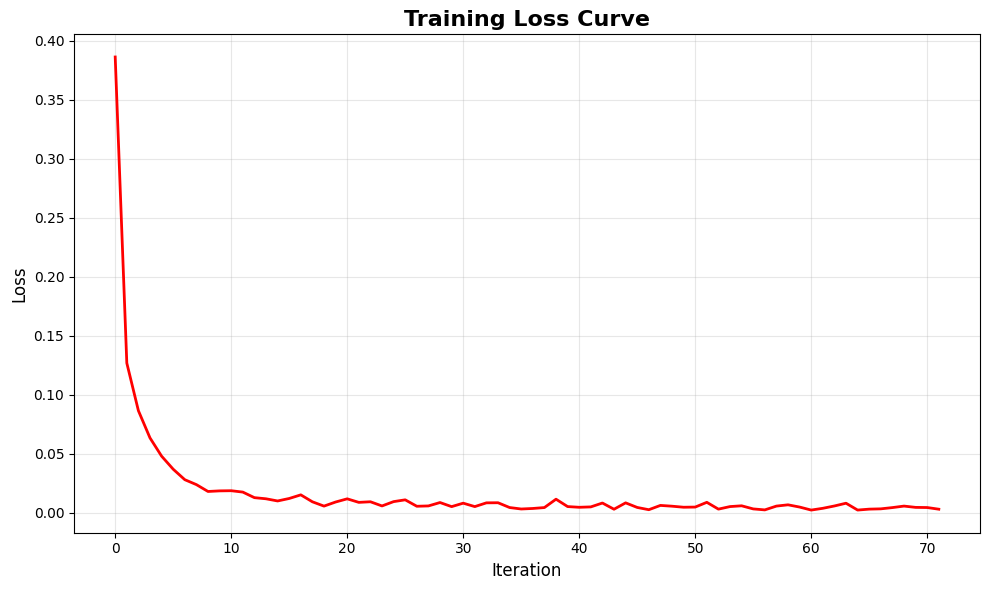

In [13]:
# Plot Training Loss Curve
plt.figure(figsize=(10, 6))
if hasattr(mlp_mnist, 'loss_curve_'):
    plt.plot(mlp_mnist.loss_curve_, color='red', linewidth=2)
    plt.title('Training Loss Curve', fontsize=16, fontweight='bold')
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.grid(True, alpha=0.3)
else:
    plt.text(0.5, 0.5, 'Loss curve not available', 
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=14)
    plt.title('Training Loss Curve', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

### `UI creation using Gradio`

In [14]:
# Define prediction function for Gradio
def predict_digit(image):
    """
    Predict digit from drawn image
    """
    if image is None:
        return "Please draw a digit", {str(i): 0.0 for i in range(10)}
    
    # Handle different input types from Gradio
    if isinstance(image, dict):
        # If it's a dictionary, extract the image data
        if 'image' in image:
            image_data = image['image']
        elif 'composite' in image:
            image_data = image['composite']
        else:
            return "Invalid image format", {str(i): 0.0 for i in range(10)}
    else:
        image_data = image
    
    # Convert to PIL Image if it's not already
    if isinstance(image_data, np.ndarray):
        # Handle different array shapes
        if len(image_data.shape) == 3 and image_data.shape[2] == 4:  # RGBA
            image_pil = Image.fromarray(image_data, mode='RGBA')
        elif len(image_data.shape) == 3 and image_data.shape[2] == 3:  # RGB
            image_pil = Image.fromarray(image_data, mode='RGB')
        else:
            image_pil = Image.fromarray(image_data)
    elif isinstance(image_data, Image.Image):
        image_pil = image_data
    else:
        return "Unsupported image format", {str(i): 0.0 for i in range(10)}
    
    # Convert to grayscale
    image_pil = image_pil.convert('L')
    
    # Resize to 28x28 (MNIST size)
    image_pil = image_pil.resize((28, 28))
    
    # Convert to numpy array
    img_array = np.array(image_pil)
    
    # Invert colors (MNIST has white digits on black background)
    img_array = 255 - img_array
    
    # Normalize
    img_array = img_array.astype('float32') / 255.0
    
    # Flatten for MLP
    img_flat = img_array.reshape(1, -1)
    
    # Get prediction probabilities
    probabilities = mlp_mnist.predict_proba(img_flat)[0]
    
    # Get predicted class
    predicted_class = np.argmax(probabilities)
    
    # Create probability dictionary
    prob_dict = {str(i): float(probabilities[i]) for i in range(10)}
    
    return f"Predicted Digit: {predicted_class}", prob_dict

In [15]:
# Create and launch Gradio interface
def create_gradio_interface():
    """
    Create Gradio interface for digit recognition
    """
    # Create the interface
    interface = gr.Interface(
        fn=predict_digit,
        inputs=gr.Sketchpad(
            canvas_size=(280, 280),
            label="Draw a digit (0-9)"
        ),
        outputs=[
            gr.Textbox(label="Prediction"),
            gr.Label(num_top_classes=10, label="Probability for each class")
        ],
        title="🔢 Handwritten Digit Recognition",
        description="Draw a digit (0-9) in the box above and get the model's prediction with probabilities for all classes.",
        examples=None,
        live=False,  # Changed to False to avoid constant updates
        theme=gr.themes.Soft()
    )
    
    return interface

In [ ]:
# Launch the interface
if __name__ == "__main__":
    # Create and launch the interface
    demo = create_gradio_interface()
    
    # Launch with public link (set share=False for local only)
    demo.launch(
        share=True,  # Set to False for local only
        debug=True,
        server_name="0.0.0.0",  # Allow external connections
    )

* Running on local URL:  http://0.0.0.0:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.
